# Capstone Project - Battle for Neighborhoods
## Final Project with Report
### Finding a good location for buying a residence home in Chicago


Factors to be considered including census information, school information and crime information. 

Some reference data to be used are from Chicago data portal. Some from Foursquare for food related.


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from colour import Color
import json
import requests

%matplotlib inline

In [2]:
#!conda install -c conda-forge folium=0.9.1 --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.9.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    folium-0.9.1               |             py_0          59 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

In [3]:
!pip install wget
!pip install folium
import wget
import folium
print(folium.__version__)

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
0.9.1


In [4]:
!wget -q -O CENSUS_DATA.csv https://ibm.box.com/shared/static/05c3415cbfbtfnr2fx4atenb2sd361ze.csv
!wget -q -O CHICAGO_PUBLIC_SCHOOLS.csv https://ibm.box.com/shared/static/f9gjvj1gjmxxzycdhplzt01qtz0s7ew7.csv
!wget -q -O CHICAGO_CRIME_DATA.csv https://ibm.box.com/shared/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv


In [5]:
import wget
url0='https://data.cityofchicago.org/api/geospatial/cauq-8yn6?method=export&format=GeoJSON'
url1='https://data.cityofchicago.org/api/geospatial/bbvz-uum9?method=export&format=GeoJSON'
url2='https://data.cityofchicago.org/api/geospatial/gdcf-axmw?method=export&format=GeoJSON'
wget.download(url0, 'chicago_c.geojson') 
wget.download(url1, 'chicago_n.geojson') 
wget.download(url2, 'chicago_z.geojson') 

#!wget -O chicago_k.geojson 'https://github.com/DSFantacy/TestDrive/raw/master/Boundaries_Community.geojson'

'chicago_z.geojson'

In [6]:
!ls -l

total 6036
-rw-r----- 1 dsxuser dsxuser    3939 Jun  4 14:00 CENSUS_DATA.csv
-rw-r----- 1 dsxuser dsxuser 2076490 Jun  4 14:00 chicago_c.geojson
-rw-r----- 1 dsxuser dsxuser  124158 Jun  4 14:00 CHICAGO_CRIME_DATA.csv
-rw-r----- 1 dsxuser dsxuser 2188793 Jun  4 14:00 chicago_n.geojson
-rw-r----- 1 dsxuser dsxuser  350911 Jun  4 14:00 CHICAGO_PUBLIC_SCHOOLS.csv
-rw-r----- 1 dsxuser dsxuser 1426275 Jun  4 14:00 chicago_z.geojson


In [20]:
### Census Data initialization and preperation
df_census = pd.read_csv('CENSUS_DATA.csv')
df_censusChicago=df_census[df_census.COMMUNITY_AREA_NAME=='CHICAGO']                           
df_census = df_census[df_census.COMMUNITY_AREA_NAME!='CHICAGO']
print(df_census.shape)
df_census.tail()

(77, 9)


,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER_CAPITA_INCOME,HARDSHIP_INDEX
72,73.0,Washington Height,1.1,16.9,20.8,13.7,42.6,19713,48.0
73,74.0,Mount Greenwood,1.0,3.4,8.7,4.3,36.8,34381,16.0
74,75.0,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30.0
75,76.0,O'Hare,3.6,15.4,7.1,10.9,30.3,25828,24.0
76,77.0,Edgewater,4.1,18.2,9.2,9.7,23.8,33385,19.0


In [34]:
### K-Means Clustering
df = df_census.drop('COMMUNITY_AREA_NUMBER', axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 

X = df.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
df["Clus_km"] = labels


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


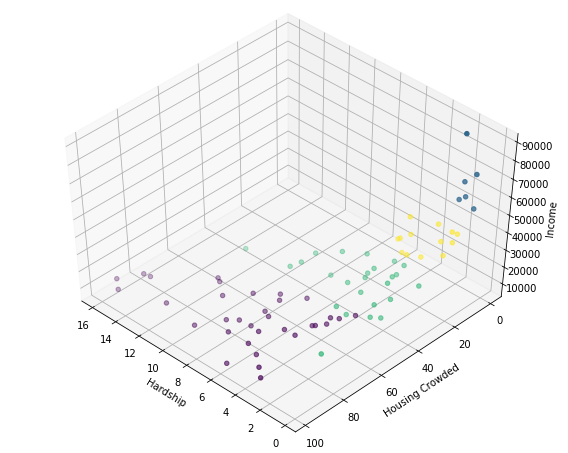

In [35]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
ax.set_xlabel('Hardship')
ax.set_ylabel('Housing Crowded')
ax.set_zlabel('Income')
ax.scatter(X[:, 0], X[:, 6], X[:, 5], c= labels.astype(np.float))

In [36]:
df_km=df.groupby('Clus_km')
print(df_km.mean())

         PERCENT OF HOUSING CROWDED  PERCENT HOUSEHOLDS BELOW POVERTY  \
Clus_km                                                                 
0                          7.324242                         30.184848   
1                          1.150000                         12.100000   
2                          3.996000                         17.492000   
3                          2.353846                         13.076923   

         PERCENT AGED 16+ UNEMPLOYED  \
Clus_km                                
0                          20.515152   
1                           5.433333   
2                          14.368000   
3                           8.838462   

         PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  \
Clus_km                                                 
0                                           29.918182   
1                                            3.950000   
2                                           17.428000   
3                                  

In [45]:
# Community area name in Group 1, which are most preferred zones. 
print(df_km.get_group(1)['COMMUNITY_AREA_NAME'])

4        North Center
5           Lake View
6        Lincoln Park
7     Near North Side
31               Loop
32    Near South Side
Name: COMMUNITY_AREA_NAME, dtype: object


In [58]:
# Get the coordinates for the K-Means clustering result Group 1
df_kmselect=pd.DataFrame({'COMMUNITY_AREA_NAME':df_km.get_group(1)['COMMUNITY_AREA_NAME']})
type(df_kmselect)

column_names=['COMMUNITY_AREA_NUMBER','COMMUNITY_AREA_NAME','Latitude','Longitude']
df_kmc=pd.DataFrame(columns=column_names)
df_kmc.tail()

for index, data in df_kmselect.iterrows():
    address = data['COMMUNITY_AREA_NAME']+", Chicago, IL"
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude    
    
    df_kmc = df_kmc.append({'COMMUNITY_AREA_NUMBER': data['COMMUNITY_AREA_NAME'],
                                      'COMMUNITY_AREA_NAME': data['COMMUNITY_AREA_NAME'],
                                      'Latitude': latitude,
                                      'Longitude': longitude}, ignore_index=True)

df_kmc.tail()


,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Latitude,Longitude
1,Lake View,Lake View,41.947050,-87.655429
2,Lincoln Park,Lincoln Park,41.921699,-87.647832
3,Near North Side,Near North Side,41.900033,-87.634497
4,Loop,Loop,41.875562,-87.624421
5,Near South Side,Near South Side,41.856700,-87.624774


In [83]:
# Show the map with selected community areas

from folium.features import DivIcon


latitude = 41.88425
longitude = -87.63245

map_chicago_kmc = folium.Map(location=[latitude, longitude], zoom_start=11)

df=df_kmc

# add markers to map
for lat, lng, ca in zip(df['Latitude'], df['Longitude'], df['COMMUNITY_AREA_NAME']):
    label = '{}'.format(ca)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_chicago_kmc)  
    
    folium.Marker(
        [lat, lng], 
        icon=DivIcon(icon_size=(120,30), 
        icon_anchor=(0,0),
        html='<div style="font-size: 12pt">%s</div>' % ca)).add_to(map_chicago_kmc)

print('map ready...')
map_chicago_kmc

map ready...


In [81]:
### School Data initialization and preperation
df_school = pd.read_csv('CHICAGO_PUBLIC_SCHOOLS.csv')
print(df_school.shape)
df_school.tail()


(566, 78)


,School ID,NAME_OF_SCHOOL,"Elementary, Middle, or High School",Street Address,City,State,ZIP Code,Phone Number,Link,Network Manager,...,Freshman on Track Rate %,X_COORDINATE,Y_COORDINATE,Latitude,Longitude,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Ward,Police District,Location
561,610172,William T Sherman Elementary School,ES,1000 W 52nd St,Chicago,IL,60609,(773) 535-1757,http://schoolreports.cps.edu/SchoolProgressRep...,AUSL Schools,...,NDA,1170500.817,1870373.159,41.799788,-87.650255,61,NEW CITY,16,9,"(41.79978772, -87.65025483)"
562,609844,William W Carter Elementary School,ES,5740 S Michigan Ave,Chicago,IL,60637,(773) 535-0860,http://schoolreports.cps.edu/SchoolProgressRep...,Burnham Park Elementary Network,...,NDA,1178101.365,1866810.123,41.789841,-87.622490,40,WASHINGTON PARK,20,2,"(41.78984129, -87.62248974)"
563,610088,Wolfgang A Mozart Elementary School,ES,2200 N Hamlin Ave,Chicago,IL,60647,(773) 534-4160,http://schoolreports.cps.edu/SchoolProgressRep...,Fullerton Elementary Network,...,NDA,1150644.396,1914368.955,41.920927,-87.721925,22,LOGAN SQUARE,35,25,"(41.92092734, -87.72192541)"
564,609977,Woodlawn Community Elementary School,ES,6657 S Kimbark Ave,Chicago,IL,60637,(773) 535-0801,http://schoolreports.cps.edu/SchoolProgressRep...,Burnham Park Elementary Network,...,NDA,1185825.188,1860883.579,41.773400,-87.594356,42,WOODLAWN,5,3,"(41.77339962, -87.59435584)"
565,610392,World Language Academy High School,HS,3120 S Kostner Ave,Chicago,IL,60623,(773) 535-4334,http://schoolreports.cps.edu/SchoolProgressRep...,West Side High School Network,...,76,1147521.302,1883405.128,41.836020,-87.734195,30,SOUTH LAWNDALE,22,10,"(41.83601953, -87.73419465)"


In [85]:
# show the map with very detailed inforamtion via data visualization
import os
from colour import Color
import math

# select circle color based on school type
def colorselect(type):
    if type == 'ES':
        return 'green'
    else:
        if type =='MS':
            return 'yellow'
        else:
            return 'blue'

colors = list(Color("orange").range_to(Color("green"),10))

df=df_school[['NAME_OF_SCHOOL','Elementary, Middle, or High School','Latitude','Longitude','SAFETY_SCORE','COLLEGE_ENROLLMENT']]
df=df.dropna()
df['SAFETY_SCORE']=df['SAFETY_SCORE']//10

latitude = 41.88425
longitude = -87.63245
print('The geograpical coordinate of Chicago is {}, {}.'.format(latitude, longitude))

map_chicago = folium.Map(location=[latitude, longitude], zoom_start=11)

## add markers to map
for lat, lng, sid, stype, safe, enrol in zip(df['Latitude'], df['Longitude'], df['NAME_OF_SCHOOL'], df['Elementary, Middle, or High School'],df['SAFETY_SCORE'],df['COLLEGE_ENROLLMENT']):
    label = '{}, {}'.format(sid, stype)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=math.sqrt(enrol)//6+4,
        popup=label,
        color=colorselect(stype),
        fill=True,
        fill_color=colors[int(safe)].hex_l,
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  

## add more marker
df=df_kmc
for lat, lng, ca in zip(df['Latitude'], df['Longitude'], df['COMMUNITY_AREA_NAME']):
    label = '{}'.format(ca)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=22,
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_chicago)  

map_chicago

The geograpical coordinate of Chicago is 41.88425, -87.63245.


In [84]:
### Crime Data initialization and preperation
df_crime = pd.read_csv('CHICAGO_CRIME_DATA.csv')
print(df_crime.shape)
df_crime.tail() 


(533, 22)


,ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,...,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,UPDATEDON,LATITUDE,LONGITUDE,LOCATION
528,10453948,HZ192829,03/01/2016 12:00:00 AM,028XX E 79TH ST,1055,HUMAN TRAFFICKING,INVOLUNTARY SERVITUDE,APARTMENT,False,False,...,7.0,46.0,26,1196679.0,1853139.0,2016,02/10/2018 03:50:01 PM,41.751885,-87.554826,"(41.751885152, -87.554825997)"
529,10397129,HZ133234,01/29/2016 03:30:00 PM,006XX W HARRISON ST,5114,NON - CRIMINAL,FOID - REVOCATION,STREET,False,False,...,2.0,28.0,26,1172257.0,1897564.0,2016,02/10/2018 03:50:01 PM,41.874363,-87.643013,"(41.874363279, -87.643013039)"
530,3269495,HJ747227,11/08/2003 04:54:15 PM,012XX W 81ST ST,510,RITUALISM,AGG RIT MUT: HANDS/FIST/FEET SERIOUS INJURY,OTHER,False,False,...,21.0,71.0,04B,1169648.0,1851076.0,2003,02/28/2018 03:56:25 PM,41.746852,-87.653941,"(41.746852486, -87.653941385)"
531,10840565,JA143710,02/06/2017 01:20:00 PM,009XX N KARLOV AVE,5073,NON-CRIMINAL (SUBJECT SPECIFIED),NOTIFICATION OF CIVIL NO CONTACT ORDER,RESIDENCE,False,True,...,37.0,23.0,26,1148881.0,1905963.0,2017,02/14/2017 03:49:42 PM,41.897895,-87.728622,"(41.89789489, -87.728622316)"
532,1326195,G021609,01/11/2001 02:30:41 AM,087XX S ESCANABA AV,9901,DOMESTIC VIOLENCE,DOMESTIC VIOLENCE,APARTMENT,True,True,...,NaN,NaN,08B,1196869.0,1847416.0,2001,08/17/2015 03:03:40 PM,41.736176,-87.554320,"(41.73617608, -87.554319607)"


In [87]:
# show the map with reported cases

import folium

    
df=df_crime[['PRIMARY_TYPE','LOCATION_DESCRIPTION','ARREST','LATITUDE','LONGITUDE']]
df=df.dropna()
print(df.shape)
latitude = 41.88425
longitude = -87.63245

chicago_geo=r'chicago_z.geojson'

print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

map_chicago_crime = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, arrest, borough, neighborhood in zip(df['LATITUDE'], df['LONGITUDE'], df['ARREST'], df['PRIMARY_TYPE'], df['LOCATION_DESCRIPTION']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red' if arrest else 'blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago_crime)  

# add more marker    
df=df_kmc
for lat, lng, ca in zip(df['Latitude'], df['Longitude'], df['COMMUNITY_AREA_NAME']):
    label = '{}'.format(ca)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=22,
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_chicago_crime) 
    
    
folium.LayerControl().add_to(map_chicago_crime)

print('map ready...')
map_chicago_crime

(529, 5)
The geograpical coordinate of Chicago are 41.88425, -87.63245.
map ready...


In [29]:
# pre-processing some data, based on the experiments and error msgs

df_crimecount=df_crime.groupby(['COMMUNITY_AREA_NUMBER'], as_index=False).count()

df_chcc=df_crimecount[['COMMUNITY_AREA_NUMBER','ID', 'COMMUNITY_AREA_NUMBER']]
df_chcc.columns=['COMMUNITY_AREA_NUMBER','COUNT', 'COMMUNITY_AREA_NAME']
print(df_chcc.head(10),df_chcc.shape)

df_cname=df_census[['COMMUNITY_AREA_NUMBER','COMMUNITY_AREA_NAME']]
df_cname['COMMUNITY_AREA_NAME']=df_cname['COMMUNITY_AREA_NAME'].str.upper()
print(df_cname.head(10), df_cname.shape)

df_cname = df_cname.merge(df_chcc[['COMMUNITY_AREA_NUMBER','COUNT']], on=['COMMUNITY_AREA_NUMBER'], how='left', suffixes=['_old', ''])
print(df_cname.head(10),df_cname.shape)

#del df_cname['COMMUNITY_AREA_NAME_old']
df_cname.fillna(1,inplace=True)
print(df_cname.head(10),df_cname.shape)

df_cname['COMMUNITY_AREA_NAME']=df_cname['COMMUNITY_AREA_NAME'].replace("O'HARE",'OHARE')
df_cname['COMMUNITY_AREA_NAME']=df_cname['COMMUNITY_AREA_NAME'].replace("MONTCLAIRE",'MONTCLARE')
df_cname['COMMUNITY_AREA_NAME']=df_cname['COMMUNITY_AREA_NAME'].replace("WASHINGTON HEIGHT",'WASHINGTON HEIGHTS')

for a in df_cname['COMMUNITY_AREA_NAME']:
    print(a)

for a in df_cname['COUNT']:
    print(a)

print(df_cname.tail(),df_cname.shape)

df_cname.info()


   COMMUNITY_AREA_NUMBER  COUNT  COMMUNITY_AREA_NAME
0                    1.0      6                  1.0
1                    2.0      7                  2.0
2                    3.0      4                  3.0
3                    4.0      3                  4.0
4                    5.0      4                  5.0
5                    6.0     11                  6.0
6                    7.0      5                  7.0
7                    8.0     15                  8.0
8                   10.0      3                 10.0
9                   11.0      2                 11.0 (70, 3)
   COMMUNITY_AREA_NUMBER COMMUNITY_AREA_NAME
0                    1.0         ROGERS PARK
1                    2.0          WEST RIDGE
2                    3.0              UPTOWN
3                    4.0      LINCOLN SQUARE
4                    5.0        NORTH CENTER
5                    6.0           LAKE VIEW
6                    7.0        LINCOLN PARK
7                    8.0     NEAR NORTH SIDE
8   

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [129]:
### Foursquare applications
import requests # library to handle requests
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import matplotlib.cm as cm
import matplotlib.colors as colors

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Get community area coordinates

column_names=['COMMUNITY_AREA_NUMBER','COMMUNITY_AREA_NAME','Latitude','Longitude']
df_commarea=pd.DataFrame(columns=column_names)
df_commarea.tail()

for index, data in df_cname.iterrows():
    address = data['COMMUNITY_AREA_NAME']+", Chicago, IL"
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude    
    
    df_commarea = df_commarea.append({'COMMUNITY_AREA_NUMBER': data['COMMUNITY_AREA_NUMBER'],
                                      'COMMUNITY_AREA_NAME': data['COMMUNITY_AREA_NAME'],
                                      'Latitude': latitude,
                                      'Longitude': longitude}, ignore_index=True)

df_commarea.tail()

,COMMUNITY_AREA_NUMBER,COMMUNITY_AREA_NAME,Latitude,Longitude
72,73.0,WASHINGTON HEIGHTS,41.706423,-87.656160
73,74.0,MOUNT GREENWOOD,41.698089,-87.708662
74,75.0,MORGAN PARK,41.690312,-87.666716
75,76.0,OHARE,41.973101,-87.906768
76,77.0,EDGEWATER,41.983369,-87.663952


In [194]:
CLIENT_ID = 'GKBBJY5RSSTFQ3JASMMEAFTE2ZJALUCMSL1HBCY5RYMVPPOT' # your Foursquare ID
CLIENT_SECRET = 'DHTWAC2RPHQWDXCC4WB21QW3A5V0PFG0ELWKHY2TEMCN0IWW' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: GKBBJY5RSSTFQ3JASMMEAFTE2ZJALUCMSL1HBCY5RYMVPPOT
CLIENT_SECRET:DHTWAC2RPHQWDXCC4WB21QW3A5V0PFG0ELWKHY2TEMCN0IWW


In [215]:
neighborhood_latitude=df_commarea[:1]['Latitude']
neighborhood_longitude=df_commarea[:1]['Longitude']

LIMIT = 100
radius = 1500

for index, data in df_commarea.iterrows():
    neighborhood_latitude = data['Latitude']
    neighborhood_longitude = data['Longitude'] 

#    print(neighborhood_latitude)
#    print(neighborhood_longitude)

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#    print(url)

In [216]:
results = requests.get(url).json()
results.get('meta')

{'code': 200, 'requestId': '5cf6c0ed9fb6b7757f2fc88e'}

In [217]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [218]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Chicagoland Games: Dice Dojo,Hobby Shop,41.983443,-87.660116
1,Little Bad Wolf,Restaurant,41.983501,-87.668938
2,Piatto Pronto,Deli / Bodega,41.984224,-87.668932
3,The Coffee Studio,Coffee Shop,41.984374,-87.669105
4,Pasteur,Asian Restaurant,41.982577,-87.659952


In [219]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [220]:
#df_comma=df_commarea.head(5)
ch_venues = getNearbyVenues(names=df_commarea['COMMUNITY_AREA_NAME'],
                                   latitudes=df_commarea['Latitude'],
                                   longitudes=df_commarea['Longitude']
                                  )

ROGERS PARK
WEST RIDGE
UPTOWN
LINCOLN SQUARE
NORTH CENTER
LAKE VIEW
LINCOLN PARK
NEAR NORTH SIDE
EDISON PARK
NORWOOD PARK
JEFFERSON PARK
FOREST GLEN
NORTH PARK
ALBANY PARK
PORTAGE PARK
IRVING PARK
DUNNING
MONTCLARE
BELMONT CRAGIN
HERMOSA
AVONDALE
LOGAN SQUARE
HUMBOLDT PARK
WEST TOWN
AUSTIN
WEST GARFIELD PARK
EAST GARFIELD PARK
NEAR WEST SIDE
NORTH LAWNDALE
SOUTH LAWNDALE
LOWER WEST SIDE
LOOP
NEAR SOUTH SIDE
ARMOUR SQUARE
DOUGLAS
OAKLAND
FULLER PARK
GRAND BOULEVARD
KENWOOD
WASHINGTON PARK
HYDE PARK
WOODLAWN
SOUTH SHORE
CHATHAM
AVALON PARK
SOUTH CHICAGO
BURNSIDE
CALUMET HEIGHTS
ROSELAND
PULLMAN
SOUTH DEERING
EAST SIDE
WEST PULLMAN
RIVERDALE
HEGEWISCH
GARFIELD RIDGE
ARCHER HEIGHTS
BRIGHTON PARK
MCKINLEY PARK
BRIDGEPORT
NEW CITY
WEST ELSDON
GAGE PARK
CLEARING
WEST LAWN
CHICAGO LAWN
WEST ENGLEWOOD
ENGLEWOOD
GREATER GRAND CROSSING
ASHBURN
AUBURN GRESHAM
BEVERLY
WASHINGTON HEIGHTS
MOUNT GREENWOOD
MORGAN PARK
OHARE
EDGEWATER


In [221]:
print(ch_venues.shape)
ch_venues.head()

(1570, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ROGERS PARK,42.010531,-87.670748,El Famous Burrito,42.010421,-87.674204,Mexican Restaurant
1,ROGERS PARK,42.010531,-87.670748,Morse Fresh Market,42.008087,-87.667041,Grocery Store
2,ROGERS PARK,42.010531,-87.670748,Bark Place,42.010080,-87.675223,Pet Store
3,ROGERS PARK,42.010531,-87.670748,Taqueria & Restaurant Cd. Hidalgo,42.011634,-87.674484,Mexican Restaurant
4,ROGERS PARK,42.010531,-87.670748,The Common Cup,42.007797,-87.667901,Coffee Shop


In [222]:
ch_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ALBANY PARK,16,16,16,16,16,16
ARCHER HEIGHTS,25,25,25,25,25,25
ARMOUR SQUARE,11,11,11,11,11,11
ASHBURN,5,5,5,5,5,5
AUBURN GRESHAM,8,8,8,8,8,8
AUSTIN,12,12,12,12,12,12
AVALON PARK,13,13,13,13,13,13
AVONDALE,34,34,34,34,34,34
BELMONT CRAGIN,14,14,14,14,14,14


In [223]:
print('There are {} uniques categories.'.format(len(ch_venues['Venue Category'].unique())))

There are 253 uniques categories.


In [224]:
# one hot encoding
ch_onehot = pd.get_dummies(ch_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ch_onehot['Neighborhood'] = ch_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ch_onehot.columns[-1]] + list(ch_onehot.columns[:-1])
ch_onehot = ch_onehot[fixed_columns]

ch_onehot.head()

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Eye Doctor,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pub,Public Art,Record Shop,Recording Studio,Rental Car Location,Rental Service,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ROGERS PARK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [225]:
ch_onehot.shape

(1570, 254)

In [226]:
ch_grouped = ch_onehot.groupby('Neighborhood').mean().reset_index()
ch_grouped

,Neighborhood,ATM,Accessories Store,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Exhibit,Eye Doctor,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lawyer,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Moving Target,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Parking,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pub,Public Art,Record Shop,Recording Studio,Rental Car Location,Rental Service,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ALBANY PARK,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.06250

In [227]:
num_top_venues = 5

for hood in ch_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ch_grouped[ch_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALBANY PARK----
            venue  freq
0  Sandwich Place  0.12
1          Bakery  0.06
2            Café  0.06
3   Grocery Store  0.06
4    Cocktail Bar  0.06


----ARCHER HEIGHTS----
                venue  freq
0   Mobile Phone Shop  0.12
1  Mexican Restaurant  0.12
2                Park  0.08
3         Gas Station  0.08
4       Grocery Store  0.08


----ARMOUR SQUARE----
                venue  freq
0  Chinese Restaurant  0.27
1      Cosmetics Shop  0.09
2  Italian Restaurant  0.09
3          Sports Bar  0.09
4         Gas Station  0.09


----ASHBURN----
                        venue  freq
0              Cosmetics Shop   0.2
1  Construction & Landscaping   0.2
2           Electronics Store   0.2
3          Italian Restaurant   0.2
4          Light Rail Station   0.2


----AUBURN GRESHAM----
                  venue  freq
0  Fast Food Restaurant  0.25
1        Cosmetics Shop  0.12
2              Pharmacy  0.12
3                Lounge  0.12
4      Greek Restaurant  0.12


----AUSTIN

In [228]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [229]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ch_grouped['Neighborhood']

for ind in np.arange(ch_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ch_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALBANY PARK,Sandwich Place,Pizza Place,Diner,Café,Fried Chicken Joint,Gas Station,Korean Restaurant,Bakery,Karaoke Bar,Cocktail Bar
1,ARCHER HEIGHTS,Mobile Phone Shop,Mexican Restaurant,Gas Station,Park,Grocery Store,Coffee Shop,Bar,Bank,Sandwich Place,Chinese Restaurant
2,ARMOUR SQUARE,Chinese Restaurant,Breakfast Spot,Italian Restaurant,Gas Station,Asian Restaurant,Sandwich Place,Sports Bar,Cosmetics Shop,Hot Dog Joint,Filipino Restaurant
3,ASHBURN,Cosmetics Shop,Construction & Landscaping,Electronics Store,Light Rail Station,Italian Restaurant,Fabric Shop,Ethiopian Restaurant,Exhibit,Eye Doctor,Farm
4,AUBURN GRESHAM,Fast Food Restaurant,Cosmetics Shop,Lounge,Caribbean Restaurant,Pharmacy,Greek Restaurant,Discount Store,Electronics Store,Ethiopian Restaurant,Exhibit


In [230]:
kclusters = 7

ch_grouped_clustering = ch_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ch_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 3, 1, 3, 1, 6, 1], dtype=int32)

In [231]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ch_merged = df_commarea[:]
print(df_commarea.head())
print(ch_merged.head())

ch_merged.rename({'COMMUNITY_AREA_NAME': 'Neighborhood'}, axis=1, inplace=True)
print(df_commarea.head())
print(ch_merged.head())

ch_merged = ch_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ch_merged.head() # check the last columns!
#for index, data in ch_merged.iterrow()
#    print(data['Neighborhood'],data['Cluster Labels'])

   COMMUNITY_AREA_NUMBER COMMUNITY_AREA_NAME   Latitude  Longitude
0                    1.0         ROGERS PARK  42.010531 -87.670748
1                    2.0          WEST RIDGE  42.003548 -87.696243
2                    3.0              UPTOWN  41.966630 -87.655546
3                    4.0      LINCOLN SQUARE  42.266997 -71.798432
4                    5.0        NORTH CENTER  41.956107 -87.679160
   COMMUNITY_AREA_NUMBER COMMUNITY_AREA_NAME   Latitude  Longitude
0                    1.0         ROGERS PARK  42.010531 -87.670748
1                    2.0          WEST RIDGE  42.003548 -87.696243
2                    3.0              UPTOWN  41.966630 -87.655546
3                    4.0      LINCOLN SQUARE  42.266997 -71.798432
4                    5.0        NORTH CENTER  41.956107 -87.679160
   COMMUNITY_AREA_NUMBER COMMUNITY_AREA_NAME   Latitude  Longitude
0                    1.0         ROGERS PARK  42.010531 -87.670748
1                    2.0          WEST RIDGE  42.003548 -87.69

,COMMUNITY_AREA_NUMBER,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1.0,ROGERS PARK,42.010531,-87.670748,6.0,Mexican Restaurant,Pizza Place,Bakery,Chinese Restaurant,Theater,Train Station,Dive Bar,Coffee Shop,Breakfast Spot,Performing Arts Venue
1,2.0,WEST RIDGE,42.003548,-87.696243,3.0,Convenience Store,Fried Chicken Joint,Bus Station,Donut Shop,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market
2,3.0,UPTOWN,41.966630,-87.655546,1.0,Coffee Shop,Pizza Place,Mexican Restaurant,Sushi Restaurant,Diner,Chinese Restaurant,Ethiopian Restaurant,Thai Restaurant,Music Venue,Mobile Phone Shop
3,4.0,LINCOLN SQUARE,42.266997,-71.798432,1.0,American Restaurant,Sandwich Place,Donut Shop,New American Restaurant,Café,Yoga Studio,Coffee Shop,Bar,Bistro,Speakeasy
4,5.0,NORTH CENTER,41.956107,-87.679160,1.0,Bar,Coffee Shop,Brewery,Video Store,Theater,Bank,Salon / Barbershop,Dive Bar,Mobile Phone Shop,Dance Studio


In [232]:
ch_merged.fillna(0, inplace=True)
for index, data in ch_merged.iterrows():
    print(data['Neighborhood'],data['Cluster Labels'])

ROGERS PARK 6.0
WEST RIDGE 3.0
UPTOWN 1.0
LINCOLN SQUARE 1.0
NORTH CENTER 1.0
LAKE VIEW 1.0
LINCOLN PARK 1.0
NEAR NORTH SIDE 1.0
EDISON PARK 1.0
NORWOOD PARK 5.0
JEFFERSON PARK 1.0
FOREST GLEN 3.0
NORTH PARK 1.0
ALBANY PARK 1.0
PORTAGE PARK 1.0
IRVING PARK 1.0
DUNNING 0.0
MONTCLARE 6.0
BELMONT CRAGIN 6.0
HERMOSA 1.0
AVONDALE 1.0
LOGAN SQUARE 1.0
HUMBOLDT PARK 5.0
WEST TOWN 1.0
AUSTIN 1.0
WEST GARFIELD PARK 3.0
EAST GARFIELD PARK 1.0
NEAR WEST SIDE 1.0
NORTH LAWNDALE 3.0
SOUTH LAWNDALE 6.0
LOWER WEST SIDE 6.0
LOOP 1.0
NEAR SOUTH SIDE 1.0
ARMOUR SQUARE 1.0
DOUGLAS 3.0
OAKLAND 5.0
FULLER PARK 3.0
GRAND BOULEVARD 1.0
KENWOOD 1.0
WASHINGTON PARK 3.0
HYDE PARK 1.0
WOODLAWN 4.0
SOUTH SHORE 1.0
CHATHAM 3.0
AVALON PARK 3.0
SOUTH CHICAGO 6.0
BURNSIDE 1.0
CALUMET HEIGHTS 3.0
ROSELAND 0.0
PULLMAN 5.0
SOUTH DEERING 1.0
EAST SIDE 1.0
WEST PULLMAN 1.0
RIVERDALE 0.0
HEGEWISCH 1.0
GARFIELD RIDGE 6.0
ARCHER HEIGHTS 1.0
BRIGHTON PARK 6.0
MCKINLEY PARK 1.0
BRIDGEPORT 1.0
NEW CITY 1.0
WEST ELSDON 6.0
GAGE 

In [233]:
# create map
import matplotlib.cm as cm
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ch_merged['Latitude'], ch_merged['Longitude'], ch_merged['Neighborhood'], ch_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters